In [1]:
# print version / should be 1.6.x
println(versioninfo())

# load centralized paths dictionary
using YAML
PATHS_FILE = "../../../PATHS.yml"
PATHS = YAML.load_file(PATHS_FILE);

"""
    load_path(keys::Vector{String}):String

Return the absolute path for a requested item within the nested PATHS dictionary.
"""
function loadpath(keys::Vector{String}):String
    # recusively assemble paths from keys
    requested_path = foldl((x, y) -> getindex(x, y), keys; init=PATHS)
    # rephrase abs path from relative paths to be platform independent.
    realpath(joinpath(splitdir(realpath(PATHS_FILE))[1], requested_path))
end;

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, haswell)
Environment:
  __LMOD_REF_COUNT_JULIA_DEPOT_PATH = /home/biotoml/.julia:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg:1
  JULIA_DEPOT_PATH = /home/biotoml/lsm/Isoprene/src/.julia/v1.7_depot:/home/biotoml/.julia:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg
  __LMOD_REF_COUNT_JULIA_LOAD_PATH = @:1;@v#.#:1;@stdlib:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6:1
  JULIA_PROJECT = /home/biotoml/lsm/Isoprene/src/.julia/v1.7
  JULIA_ROOT = /sw/comp/julia/1.6.3/rackham
  JULIA_LOAD_PATH = @:@v#.#:@stdlib:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6
nothing


In [2]:
using CSV
using Chain
using Plots
using NCDatasets
using Revise

# How much input can we get from other CliMA models?

## Macroecology of CliMA models

Actually, the [CliMA](https://clima.caltech.edu/) models are designed in a way that allows to connect them all. There is a [blog entry](https://clima.caltech.edu/2022/02/09/toward-a-new-earth-system-model-clima-at-agu/) about it, but [this poster](https://clima.caltech.edu/files/2022/02/MackayAGU.pdf) explains it best:

<details style="background-color:#eeeeee">
    <summary>Show poster:</summary>
    <embed type="application/pdf" src="https://clima.caltech.edu/files/2022/02/MackayAGU.pdf#toolbar=0" width="50%">
    </embed>
</details>

In short, [`ClimaCoupler.jl`](https://github.com/CliMA/ClimaCoupler.jl) is designed to do this mediation between different models. 

Another design choice of CliMA models is [`ClimaCore.jl`](https://github.com/CliMA/ClimaCore.jl), an interface that allows to felixible space discretizations and thus delivers a base for all models. [Here](https://agu2021fallmeeting-agu.ipostersessions.com/default.aspx?s=43-72-C2-E4-F0-E6-33-EE-F7-EC-3E-83-8D-5C-E8-63&guestview=true) is some more explanation:

<details style="background-color:#eeeeee">
    <summary>Show poster:</summary>
    <iframe src="https://agu2021fallmeeting-agu.ipostersessions.com/default.aspx?s=43-72-C2-E4-F0-E6-33-EE-F7-EC-3E-83-8D-5C-E8-63&guestview=true" style="width:50%">
    </iframe>
</details>

To understand `ClimaCore.jl` a bit better, I did the [tutorial](https://github.com/CliMA/ClimaWorkshops) which I stored in the [`ext_src` directory](../../../ext_src/02_tutorials/01_climacore/ClimaWorkshops/README.md). The tutorial is very technical, with a soild underlying mathematical concept. I like that, though it is very difficult for me to understand. 

## Available CliMA models

In the mid of June 2022, I summarized the available CliMA packages:

<details style="background-color:#eeeeee">
    <summary>Show all models june:</summary>
    <table>
	<thead>
		<tr>
			<th>Model</th>
			<th>Last commit</th>
			<th>Link</th>
			<th>Type</th>
			<th>Keywords</th>
			<th>Using models</th>
			<th>Main contributors</th>
			<th>Useful for us</th>
			<th>Information</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>Core models</td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>Oceananigans.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/Oceananigans.jl</td>
			<td>global process model</td>
			<td>ocean, fluid dynamics, convection</td>
			<td>GeophysicalDissipation.jl, OceanModelComparison.jl, ClimaSimulations.jl, OceanParameterizations.jl, ParameterEstimocean.jl, LESbrary.jl</td>
			<td>Ramadhan, Wagner, Constantinou, Silvestri, Poulin, Chor</td>
			<td>No, we do not need ocean currents for LSMs.</td>
			<td>Model framwork to simulate global water dynamics. Runs conducted and stored by LESbrary.jl. This model is wonderfully documented.</td>
		</tr>
		<tr>
			<td>ClimaAtmos.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/ClimaAtmos.jl</td>
			<td>global process model</td>
			<td>global, atmosphere, dynamics</td>
			<td>ClimaCoupler.jl</td>
			<td>Kawczynski,Noguera Souza, Bischoff, Sridhar, Shen</td>
			<td>Yes, data of atmospheric compounds/properties</td>
			<td>Global model for dynamics of the atmosphere; still some things are missing but in construction.</td>
		</tr>
		<tr>
			<td>ClimaLSM.jl</td>
			<td>2022-06-10</td>
			<td>https://github.com/CliMA/ClimaLSM.jl</td>
			<td>global process model</td>
			<td>land, soil, vegetation</td>
			<td></td>
			<td>Deck, Mackay</td>
			<td>Yes, soil hydrology and other land parameters. Could be base for new implementations rather than CliMA Land</td>
			<td>Land surface model that should allow single and multicomponent models. This should take over some functionalities form ClimaCoupler.jl</td>
		</tr>
		<tr>
			<td>LandHydrology.jl</td>
			<td>2021-11-10</td>
			<td>https://github.com/CliMA/LandHydrology.jl</td>
			<td>global process model</td>
			<td>land, water, soil, heat</td>
			<td>ClimaCoupler.jl</td>
			<td>Kawczynski, Deck, Mackay</td>
			<td>No, I think the other land connected models have better implementations of the hydrology processes</td>
			<td>Model that simulates soil hydrology and heat fluxes.</td>
		</tr>
		<tr>
			<td>Land</td>
			<td>2022-05-23</td>
			<td>https://github.com/CliMA/Land</td>
			<td>global process model</td>
			<td>soil, hydrology, land</td>
			<td></td>
			<td>Frankenberg, Wang, Braghiere, Kawczynski</td>
			<td>Yes, this should be the base of our model</td>
			<td>Land surface model with detailed implementation of stomatal response.</td>
		</tr>
		<tr>
			<td>ClimateMachine.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/ClimateMachine.jl</td>
			<td>global process model</td>
			<td>ocean, land, atmosphere, machine learning, earth system model</td>
			<td>GeophysicalDissipation.jl, OceanModelComparison.jl, ClimaCoupler.jl</td>
			<td>Kawczynski, Byrne, Sridhar, Waruszewski, Willcox, Gibson, Pamnany</td>
			<td>Yes, data for atmopheric and land parameters from simulations</td>
			<td>Large modular model for dynamics of land, atmosphere and ocean processes; using machine learning (EKM).</td>
		</tr>
		<tr>
			<td>Process models</td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>Insolation.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/Insolation.jl</td>
			<td>physical process model</td>
			<td>solar zenith, angle, atmosphere, light</td>
			<td>RRTMGP.jl*, ClimaAtmos.jl*</td>
			<td>Singer, Kawczynski</td>
			<td>Yes, to compute radiation intensity of photosynthesis</td>
			<td>For calculation of solar angle and insolation of place on planet at given time; important for computation of radiation.</td>
		</tr>
		<tr>
			<td>RRTMGP.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/RRTMGP.jl</td>
			<td>physical process model</td>
			<td>radiation, optics, atmosphere</td>
			<td>ClimaAtmos.jl, ClimaCoupler.j</td>
			<td>Kawczynski, Kandala</td>
			<td>Yes, to compute radiation intensity of photosynthesis</td>
			<td>Describing radiative fluxes within the atmosphere based on optical and thermodynamic contexts. For use in ClimaAtmos model.</td>
		</tr>
		<tr>
			<td>TurbulenceConvection.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/TurbulenceConvection.jl</td>
			<td>physical process model</td>
			<td>eddy mass-flux, clouds, turbulence, single column, atmosphere</td>
			<td>ClimateMachine.jl, CalibrateEDMF.jl, ClimaAtmos.jl</td>
			<td>Lopez-Gomez, Kawczynski, Langeland Ervik, Christopoulos, Cohen, Jaruga, Kaul, Pressel</td>
			<td>No, using ClimaAtmos (gridded implementation) should be enough</td>
			<td>Single column model of atmospheric mass fluxes; mostly eddy-diffusivity models.</td>
		</tr>
		<tr>
			<td>Kinematic1D.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/Kinematic1D.jl</td>
			<td>physical process model</td>
			<td>rain, atmosphere, heat</td>
			<td></td>
			<td>Jaruga, Jong</td>
			<td>No</td>
			<td>Kinematic model of warm rain for atmosphere model; in construction.</td>
		</tr>
		<tr>
			<td>CloudMicrophysics.jl</td>
			<td>2022-06-17</td>
			<td>https://github.com/CliMA/CloudMicrophysics.jl</td>
			<td>physical process model</td>
			<td>atmosphere, clouds, heat, temperature</td>
			<td>ClimateMachine.jl, Kinematic1D.jl, TurbulenceConvection.jl, EnsembleKalmanProcesses.jl, ClimaAtmos.jl</td>
			<td>Jaruga, Kawczynski</td>
			<td>No, I think that would be too fine-grained</td>
			<td>For simulating cloud formation based on microphysical processes.</td>
		</tr>
		<tr>
			<td>Thermodynamics.jl</td>
			<td>2022-06-17</td>
			<td>https://github.com/CliMA/Thermodynamics.jl</td>
			<td>physical process model</td>
			<td>atmosphere, vapor, thermodynamics, water</td>
			<td>ClimaCoupler.jl, SingleColumnModels.jl, ClimateMachine.jl, GeophysicalDissipation.jl, CloudMicrophysics.jl, ClimaAtmos.jl, SurfaceFluxes.jl, TurbulenceConvection.jl, LandHydrology.jl, ClimaLSM.jl</td>
			<td>Jaruga, Kawczynski</td>
			<td>No, using ClimaAtmos (gridded implementation) should be enough</td>
			<td>Modeling framework for moist thermodynamics in the atmosphere.</td>
		</tr>
		<tr>
			<td>SeawaterPolynomials.jl</td>
			<td>2022-05-06</td>
			<td>https://github.com/CliMA/SeawaterPolynomials.jl</td>
			<td>physical process model</td>
			<td>ocean, seawater density</td>
			<td>Oceananigans.jl, LESbrary.jl</td>
			<td>Wagner, Constantinou, Souza</td>
			<td>No</td>
			<td>For computing the density of seawaters.</td>
		</tr>
		<tr>
			<td>SingleColumnModels.jl</td>
			<td>2021-06-15</td>
			<td>https://github.com/CliMA/SingleColumnModels.jl</td>
			<td>physical process model</td>
			<td>atmosphere, no insights</td>
			<td></td>
			<td>Kawczynski</td>
			<td>No</td>
			<td>Model with unknown use. Probably depreceated.</td>
		</tr>
		<tr>
			<td>Modularization tools</td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>ClimaCoupler.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/ClimaCoupler.jl</td>
			<td>modularization tool</td>
			<td>ocean, land, atmosphere, coupling, boundaries, global</td>
			<td></td>
			<td>Mackay, Novak, Hill, Kawczynski</td>
			<td>Maybe the tool to connect can the other models output with the CliMA Land run</td>
			<td>Coupler to connect boundary components and fluxes between different models of the CliMA framework (e.g. oceans and atmosphere).</td>
		</tr>
		<tr>
			<td>SurfaceFluxes.jl</td>
			<td>2022-06-18</td>
			<td>https://github.com/CliMA/SurfaceFluxes.jl</td>
			<td>modularization tool</td>
			<td>surface fluxes, boundaries, heat, water, atmosphere, land, ocean</td>
			<td>LandHydrology.jl, ClimateMachine.jl, ClimaLSM.jl, ClimaAtmos.jl, ClimaCoupler.jl, TurbulenceConvection.jl</td>
			<td>Kawczynski</td>
			<td>Maybe the tool to connect can the other models output with the CliMA Land run</td>
			<td>Surface model for common parameters and fluxes (heat, friction, …) between land, water and air.</td>
		</tr>
		<tr>
			<td>ClimaCore.jl</td>
			<td>2022-06-17</td>
			<td>https://github.com/CliMA/ClimaCore.jl</td>
			<td>modularization tool</td>
			<td>dynamic core, mathematics, operators, grid, spatial discretization</td>
			<td>ClimaCoupler.jl, LandHydrology.jl, CalibrateEDMF.jl, ClimaAtmos.jl, ClimaLSM.jl, TurbulenceConvection.jl, Kinematic1D.jl</td>
			<td>Byrne, Bolwski, Barra, Kawczynski, Kandala</td>
			<td>Yes, could be the spatial core for the single-grid-cell models</td>
			<td>Model core framework for grid simulations that allow operations between nodes and on different topologies.</td>
		</tr>
		<tr>
			<td>CLIMAParameters.jl</td>
			<td>2022-06-07</td>
			<td>https://github.com/CliMA/CLIMAParameters.jl</td>
			<td>modularization tool</td>
			<td>parameter, physics, chemistry, constants</td>
			<td>LandHydrology.jl, SingleColumnModels.jl,  ClimaLSM.jl, ClimateMachine.jl, ClimaCoupler.jl, GeophysicalDissipation.jl, ClimaAtmos.jl, OceanModelComparison.jl, Thermodynamics.jl, Kinematic1D.jl, Insolation.jl, RRTMGP.jl, SurfaceFluxes.jl, TurbulenceConvection.jl, CloudMicrophysics.jl</td>
			<td>Jaruga, Kawczynski</td>
			<td>Yes, for important parameters!</td>
			<td>Package that stores nature constants for all CliMA packages.</td>
		</tr>
		<tr>
			<td>ClimaTimeSteppers.jl</td>
			<td>2022-06-02</td>
			<td>https://github.com/CliMA/ClimaTimeSteppers.jl</td>
			<td>modularization tool</td>
			<td>mathematics, time, operators, dynamics</td>
			<td>ClimaCore.jl</td>
			<td>Byrne, Gibson</td>
			<td>Maybe, by using ClimaCore.jl</td>
			<td>Temporal solver of dynamic equations.</td>
		</tr>
		<tr>
			<td>ClimaComms.jl</td>
			<td>2022-04-13</td>
			<td>https://github.com/CliMA/ClimaComms.jl</td>
			<td>modularization tool</td>
			<td>computation, distributed computing</td>
			<td>ClimaCoupler.jl, ClimaCore.jl, ClimaAtmos.jl</td>
			<td>Pamnany, Byrne, Kandala, Bolewski</td>
			<td>Maybe, for distributed runs</td>
			<td>Tool to run (multicomponent) models on multiple cores</td>
		</tr>
		<tr>
			<td>Data organization tools</td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>LESbrary.jl</td>
			<td>2022-06-16</td>
			<td>https://github.com/CliMA/LESbrary.jl</td>
			<td>data organization tool</td>
			<td>ocean, library, turbulence</td>
			<td></td>
			<td>Ramadhan, Wagner</td>
			<td>No</td>
			<td>Library of ocean eddy flux simulations from Oceananigans.jl</td>
		</tr>
		<tr>
			<td>AtmosphericProfilesLibrary.jl</td>
			<td>2022-03-09</td>
			<td>https://github.com/CliMA/AtmosphericProfilesLibrary.jl</td>
			<td>data organization tool</td>
			<td>atmosphere, library, atmospheric profiles</td>
			<td>ClimaAtmos.jl, TurbulenceConvection.jl</td>
			<td>Jaruga, Kawczynski</td>
			<td>No</td>
			<td>Package that stores important different profile functions of the atmosphere as published in several works.</td>
		</tr>
		<tr>
			<td>GriddingMachine.jl</td>
			<td>2022-05-31</td>
			<td>https://github.com/CliMA/GriddingMachine.jl</td>
			<td>data organization tool</td>
			<td>land, canopy, biomass, library</td>
			<td></td>
			<td>Wang</td>
			<td>Maybe, as source for gridded data input. Still, as it is not connected with the other core models, it may be better to use them for gridding an external datasource (maybe torchgeo?)</td>
			<td>Framework providing functions to load and scale geographical, land and vegetation data on a gridded manner. Designed for CliMA Land.</td>
		</tr>
		<tr>
			<td>Optimization tools</td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>CalibrateEDMF.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/CalibrateEDMF.jl</td>
			<td>model optimization tool</td>
			<td>turbulence, kalman, atmosphere</td>
			<td></td>
			<td>Lopez-Gomez, Kawczynski, Langeland Ervik, Christopoulos, Cohen</td>
			<td>Maybe the method, to estimate parameters of stomatal models?!</td>
			<td>For parametrization and calibration of atmospheric turbulence and convection; using ensemble Kalman inversion. Used for atmosphere models.</td>
		</tr>
		<tr>
			<td>ParameterEstimocean.jl</td>
			<td>2022-06-20</td>
			<td>https://github.com/CliMA/ParameterEstimocean.jl</td>
			<td>model optimization tool</td>
			<td>ocean turbulence, kalman, water</td>
			<td></td>
			<td>Constantinou, Hillier, Wagner</td>
			<td>Maybe the method, to estimate parameters of stomatal models?! The application of the tool and description of the problem is very well explained.</td>
			<td>For parametrization of ocean dynamics; using ensemble Kalman inversion. Used for ocean models.</td>
		</tr>
		<tr>
			<td>CalibrateEmulateSample.jl</td>
			<td>2022-06-17</td>
			<td>https://github.com/CliMA/CalibrateEmulateSample.jl</td>
			<td>model optimization tool</td>
			<td>parameter calibration, sampling, emulation, modular, mathematics, kalman</td>
			<td></td>
			<td>Kawczynski, Burov, Howland, Jackson</td>
			<td>Maybe the method, to estimate parameters of stomatal models?! Maybe we could use the Emulator interface for our emulator</td>
			<td>Parameter estimation framework using inversion of ensemble kalman processes, emulation (e.g. GPs) and sampling.</td>
		</tr>
		<tr>
			<td>EnsembleKalmanProcesses.jl</td>
			<td>2022-06-17</td>
			<td>https://github.com/CliMA/EnsembleKalmanProcesses.jl</td>
			<td>model optimization tool</td>
			<td>parameter calibration, modular, mathematics, kalman</td>
			<td>CalibrateEDMF.jl, ParameterEstimocean.jl, CalibrateEmulateSample.jl</td>
			<td>Lopez-Gomez, Constantinou, Bolewski, Garbuno Inugo</td>
			<td>Maybe the method, to estimate parameters of stomatal models?!</td>
			<td>Implementation of solvers of (inverse) problems of ensemble kalman processes.</td>
		</tr>
		<tr>
			<td>OceanParameterizations.jl</td>
			<td>2021-11-12</td>
			<td>https://github.com/CliMA/OceanParameterizations.jl</td>
			<td>model optimization tool</td>
			<td>ocean, parametrization</td>
			<td></td>
			<td>Ramadhan, Lee, Hillier, Piterbarg</td>
			<td>No</td>
			<td>Optimizing simulations of the oceans model</td>
		</tr>
		<tr>
			<td>GeophysicalDissipation.jl</td>
			<td>2021-01-15</td>
			<td>https://github.com/CliMA/GeophysicalDissipation.jl</td>
			<td>model optimization tool</td>
			<td>testing, ocean</td>
			<td></td>
			<td>Souza</td>
			<td>No</td>
			<td>Testing of ocean simulations.</td>
		</tr>
		<tr>
			<td>Solvent.jl</td>
			<td>2020-11-09</td>
			<td>https://github.com/CliMA/Solvent.jl</td>
			<td>model optimization tool</td>
			<td>mathematics, dynamics</td>
			<td></td>
			<td>Gibson, Yatunin</td>
			<td>No</td>
			<td>For solving linear PDEs on GPUs and CPUs.</td>
		</tr>
		<tr>
			<td>Pure mathematics/discretization/coding tools</td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
			<td></td>
		</tr>
		<tr>
			<td>CubedSphere.jl</td>
			<td>2021-10-21</td>
			<td>https://github.com/CliMA/CubedSphere.jl</td>
			<td>model optimization tool</td>
			<td>mathematics, discretization, dynamics</td>
			<td>Oceananigans.jl, ClimateMachine.jl</td>
			<td>Ramadhan, Byrne, Hill</td>
			<td>Maybe, for modelling a globe</td>
			<td>Framework providing PDE solvers and structures of cubed sphere grids.</td>
		</tr>
		<tr>
			<td>NonlinearSolvers.jl</td>
			<td>2021-09-13</td>
			<td>https://github.com/CliMA/NonlinearSolvers.jl</td>
			<td>model optimization tool</td>
			<td>mathematics, dynamics</td>
			<td>ClimaCoupler.jl</td>
			<td>Kawczynski</td>
			<td>No</td>
			<td>For solving Nonlinear PDEs on GPUs and CPUs.</td>
		</tr>
		<tr>
			<td>ReportMetrics.jl</td>
			<td>2022-04-06</td>
			<td>https://github.com/CliMA/ReportMetrics.jl</td>
			<td>modularization tool</td>
			<td>documentation, testing</td>
			<td>ClimaCore.jl, Thermodynamics.jl</td>
			<td>Kawczynski</td>
			<td>Maybe, for running tests</td>
			<td>Tool to report data allocation of code.</td>
		</tr>
		<tr>
			<td>GilbertCurves.jl</td>
			<td>2022-03-11</td>
			<td>https://github.com/CliMA/GilbertCurves.jl</td>
			<td>modularization tool</td>
			<td>mathematics, dynamics</td>
			<td>ClimaCore.jl</td>
			<td>Byrne, Gupta</td>
			<td>No</td>
			<td>Mathematical framework that implements spacefilling generalized hilbert curves.</td>
		</tr>
		<tr>
			<td>GCMMesh</td>
			<td>2021-12-17</td>
			<td>https://github.com/CliMA/GCMMesh</td>
			<td>modularization tool</td>
			<td>computation, grid, meshes</td>
			<td></td>
			<td>Byrne, Kandala</td>
			<td>No</td>
			<td>Tools to compute meshes and partitions of box and spherical shell domains</td>
		</tr>
		<tr>
			<td>CGDycore.jl</td>
			<td>2022-03-24</td>
			<td>https://github.com/CliMA/CGDycore.jl</td>
			<td>modularization tool</td>
			<td>mathematics</td>
			<td></td>
			<td>Knoth, Kawczynski</td>
			<td>No</td>
			<td>Nowhere used, neither mentioned. Seems to be a translation of a dynamic weather prediction in MatLab called WeatherCG.</td>
		</tr>
		<tr>
			<td>RootSolvers.jl</td>
			<td>2022-06-10</td>
			<td>https://github.com/CliMA/RootSolvers.jl</td>
			<td>modularization tool</td>
			<td>mathematics</td>
			<td>Thermodynamics.jl, SurfaceFluxes.jl, ClimaCore.jl</td>
			<td>Kawczynski, Bolweski</td>
			<td>No</td>
			<td>Tool that allows to solve roots on GPUs.</td>
		</tr>
		<tr>
			<td>OperatorFlux.jl</td>
			<td>2022-05-16</td>
			<td>https://github.com/CliMA/OperatorFlux.jl</td>
			<td>modularization tool</td>
			<td>mathematics, machine learning, dynamics</td>
			<td>TurbulenceConvection.jl</td>
			<td>Bischoff, Kawczynski</td>
			<td>Yes, actually this (or NeuralOperators.jl) could be used as neural operator</td>
			<td>Neural operators for modeling dynamics; was unified with SciML/NeuralOperators.jl</td>
		</tr>
	</tbody>
</table>
    </details>

## `GriddingMachine.jl`

This is a data ressource engine for spatiotemporal data that should be fed griddedly into the LSM. It is built on the julia `Artifacts` idea ([more info here](https://www.juliafordatascience.com/artifacts/)) and is a kind of data loader.

We download all gridded datasets to our `artifacts`/`JULIA_DEPOT_PATH` directory.

In [3]:
using GriddingMachine: Collector

┌ Info: Precompiling GriddingMachine [f20cf718-bf4d-4727-bc8f-485b1f283ac6]
└ @ Base loading.jl:1423


In [11]:
"""
    fetch_collection(collection::Symbol)

Fetch `GriddingMachine.jl` collection to be stored in depot path.
"""
function fetch_collection(collection::Symbol)
    combo = ""
    collection_method = "Collector.$(string(collection))()";
    println(collection_method);
    method = eval(Meta.parse(collection_method));
    
    # show the available versions
    @show method.DEFAULT_COMBO;
    @show method.SUPPORTED_COMBOS;
    
    # download the file
    file = Collector.query_collection(method);
    @show file;
end;

In [12]:
@chain names(Collector) begin
    (x -> string(x)).(_)
    filter(x -> islowercase(x[1]), _)
    filter(x -> findnext("!", x, 1) === nothing, _)
    filter(x -> findnext("query", x, 1) === nothing, _)
    collections = (x -> Symbol(x)).(_)
end;

In [13]:
collectionfiles = (x -> fetch_collection(x)).(collections);

Collector.biomass_collection()
method.DEFAULT_COMBO = "SHOOT_120X_1Y_V2"
method.SUPPORTED_COMBOS = ["ROOT_120X_1Y_V1", "SHOOT_120X_1Y_V2"]
file = "/home/biotoml/lsm/Isoprene/src/.julia/v1.7_depot/artifacts/f3a9530cb23714c5d2a3863a7317ff2bfb32077a/BIOMASS_SHOOT_120X_1Y_V2.nc"
Collector.canopy_height_collection()
method.DEFAULT_COMBO = "20X_1Y_V1"
method.SUPPORTED_COMBOS = ["20X_1Y_V1", "2X_1Y_V2"]
file = "/home/biotoml/lsm/Isoprene/src/.julia/v1.7_depot/artifacts/8e82b3b97603651740df68ff493cb497c6f7b486/CH_20X_1Y_V1.nc"
Collector.clumping_index_collection()
method.DEFAULT_COMBO = "2X_1Y_V1"
method.SUPPORTED_COMBOS = ["240X_1Y_V1", "2X_1Y_V1", "2X_1Y_V2"]
file = "/home/biotoml/lsm/Isoprene/src/.julia/v1.7_depot/artifacts/bf4a75248eac9eac8e2f89e7634f30f1ca44174c/CI_2X_1Y_V1.nc"
Collector.elevation_collection()
method.DEFAULT_COMBO = "4X_1Y_V1"
method.SUPPORTED_COMBOS = ["4X_1Y_V1"]
file = "/home/biotoml/lsm/Isoprene/src/.julia/v1.7_depot/artifacts/8982c2361022359a3a954d9f35b65d48f6b9f39b/

┌ Warning: This dataset is only meant for those who has reached to the authors (Croft et al) for permissions. We (developers of GriddingMachine) are not responsible for unauthorized usage
└ @ GriddingMachine.Collector /home/biotoml/.julia/packages/GriddingMachine/9C9PE/src/Collector.jl:366


:::{warning}
Warning: This dataset is only meant for those who has reached to the authors (Croft et al) for permissions. We (developers of GriddingMachine) are not responsible for unauthorized usage
:::

In [7]:
"""
    plot_ncdf(netcdfile::AbstractString)

Visualize geographical NetCDF file. File must list 2D geospatial scalar values
as `data` variable. The dimension axes must be named `lon` and `lat`.
"""
function plot_ncdf(netcdfile::AbstractString)
    # load dataset with NCDataset. Alternatively one could use NetCDF.jl,
    # but they should be merged one day (acc. to julia slack).
    ds = NCDataset(netcdfile);

    # store axis and z-data
    ncvar = ds["data"][:, :];
    lon = ds["lon"][:];
    lat = ds["lat"][:];
    
    # make plot
    heatmap(lon, lat, ncvar', c=:Cassatt2);
    title!(splitdir(netcdfile)[2]);
    xlabel!("longitude");
    ylabel!("latitude");
end

plot_ncdf

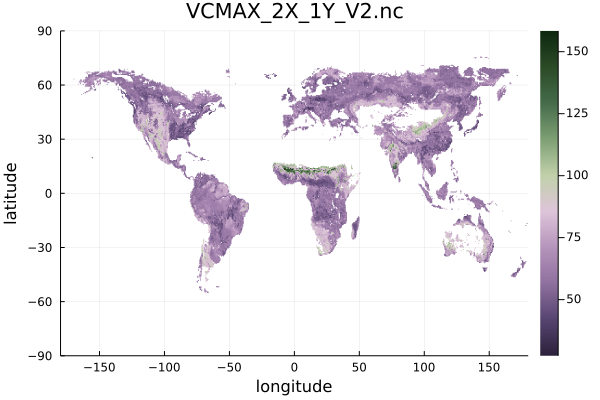

In [33]:
gr()
plot_ncdf(collectionfiles[21])

In [ ]:
plot_ncdf(collectionfiles[2])

In [12]:
Collector.biomass_collection()


    LABEL            ⇨ "BIOMASS"
    SUPPORTED_COMBOS ⇨ [
                        "ROOT_120X_1Y_V1",
                        "SHOOT_120X_1Y_V2"
                       ]
    DEFAULT_COMBO    ⇨ "SHOOT_120X_1Y_V2"


In [19]:
for collection in collections
    collection_method = "Collector.$(string(collection))()"
    println(collection_method)
    v = eval(Meta.parse(collection_method))
end

Collector.biomass_collection()
Collector.canopy_height_collection()
Collector.clumping_index_collection()
Collector.elevation_collection()
Collector.gpp_collection()
Collector.lai_collection()
Collector.land_mask_collection()
Collector.latent_heat_collection()
Collector.leaf_chlorophyll_collection()
Collector.leaf_drymass_collection()
Collector.leaf_nitrogen_collection()
Collector.leaf_phosphorus_collection()
Collector.pft_collection()
Collector.sif_collection()
Collector.sil_collection()
Collector.sla_collection()
Collector.soil_color_collection()
Collector.soil_hydraulics_collection()
Collector.surface_area_collection()
Collector.tree_density_collection()
Collector.vcmax_collection()
Collector.wood_density_collection()


┌ Warning: This dataset is only meant for those who has reached to the authors (Croft et al) for permissions. We (developers of GriddingMachine) are not responsible for unauthorized usage
└ @ GriddingMachine.Collector /home/biotoml/.julia/packages/GriddingMachine/9C9PE/src/Collector.jl:366


In [6]:
using ClimateTools

LoadError: ArgumentError: Package ClimateTools not found in current path:
- Run `import Pkg; Pkg.add("ClimateTools")` to install the ClimateTools package.
